In [1]:
import os
import sys
import warnings
import random 

working_dir = os.getcwd()
if working_dir.endswith("drivenData/pumpitup/notebooks"):
    os.chdir("../")

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

#Custom function
from src.data import make_dataset

In [2]:
training_data = make_dataset.merge("../data/raw/trainingdata.csv","../data/raw/traininglabels.csv",for_eda = True)

In [3]:
training_data.shape

(59400, 41)

In [4]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', 50):
    display(training_data.head())

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  \
0  34.938093  -9.856322                  none            0   
1  34.698766  -2.147466              Zahanati            0   
2  37.460664  -3.821329           Kwa Mahundi            0   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False               1999   
1             Other                          NaN   True               2010   
2               VWC  Nyumba ya mungu pipe scheme   True               2009   
3               VWC                          NaN   True               1986   
4               NaN                          NaN   True                  0   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  \
0  groundwater           communal standpipe    communal standpipe   
1      surface           communal standpipe    communal standpipe   
2      surface  communal standpipe multiple    communal standpipe   
3  groundwater  communal standpipe multiple    communal standp

In [5]:
training_data.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [6]:
cols_to_drop = []
def get_na_columns(df,threshold):
    threshold_level = df.shape[0]*threshold
    return [c for c in df.columns if df[c].isna().sum() > threshold_level]
cols_to_drop = cols_to_drop + get_na_columns(training_data, 0.00)#Remove all na columns for now

In [7]:
print(cols_to_drop)

['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']


Let's go through each remaining feature one by one. We will build some custom functions that will give us a snapshot of the data.

In [8]:
#Consider only remaining columns which have significance.
remaining_cols = [col for col in training_data.columns if col not in cols_to_drop]
print(remaining_cols)

['id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'recorded_by', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [9]:
t_df = training_data[remaining_cols] #temp_df

#custom describe function
def describe_df(df):
    if not (isinstance(df, pd.core.frame.DataFrame)):
        raise TypeError("Type exception occured. Expecting a dataframe.")
    df_cols = df.columns
    out_cols = ['name','type','first_five','last_five','unique_values','total_values','na_values']
    out_df = pd.DataFrame(columns = out_cols)
    for col in df_cols:
        out_dict = {}
        out_dict['name'] = col
        out_dict['type'] = df[col].dtype
        out_dict['first_five'] = list(df[col].head())
        out_dict['last_five']  = list(df[col].tail())
        out_dict['unique_values'] = len(df[col].unique())
        out_dict['total_values'] = len(df[col])
        out_dict['na_values'] = (df[col].isna().sum())
        out_df = out_df.append(out_dict, ignore_index =True)
    return out_df

In [10]:
class ValidationError(Exception):
    def __init__(self, message, errors):

        # Custom Exception class with minimal functionality.
        super(ValidationError, self).__init__(message)
        print(errors)
def get_contingency_table(df):
    '''
        Used for visualising relationships between two categorical variables
    '''
    if not (isinstance(df, pd.core.frame.DataFrame)):
        raise TypeError("Type exception occured. Expecting a dataframe.")
    col_df = df.columns
    if (len(col_df) > 2):
        raise ValidationError("Dataframe must have only two columns.",col_df)
    return pd.crosstab(index = df[col_df[0]], columns = df[col_df[1]])
def get_color_map(target_variable):
    '''
        Used to generate custom colors to use in plotting later.
    '''
    if target_variable == 'functional':
        return 'green'
    elif target_variable == 'non functional':
        return 'red'
    elif target_variable == 'funtional needs repair':
        return 'yellow'
def get_box_plot(df, target_column_index = 1):
    '''
        Used for visualising relationships between a continous variable (independent) and a categorical variable (dependent)
    '''
    if not (isinstance(df, pd.core.frame.DataFrame)):
        raise TypeError("Type exception occured. Expecting a dataframe.")
    col_df = df.columns
    if (len(col_df) > 2):
        raise ValidationError("Dataframe must have only two columns.",col_df)
    #flag to know which is the target column/dependent variable.
    if target_column_index == 1:
        x_index,y_index = 1,0
    elif target_column_index == 0:
        x_index,y_index = 0,1
    else:
        raise ValidationError("target_column_index must be set to 0 or 1.",target_column_index)
    sns.boxplot(x=df.columns[x_index], y=df.columns[y_index], data=t_df)
    plt.show()

Feature Name:  id
Feature Type:  int64
Sample Data:  [69572, 8776, 34310, 67743, 19728] ...... [60739, 27263, 37057, 31282, 26348]


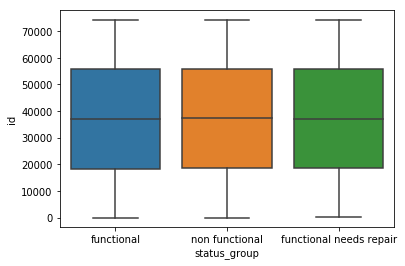

Feature Name:  amount_tsh
Feature Type:  float64
Sample Data:  [6000.0, 0.0, 25.0, 0.0, 0.0] ...... [10.0, 4700.0, 0.0, 0.0, 0.0]


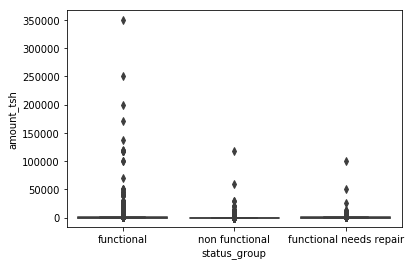

Feature Name:  date_recorded
Feature Type:  object
Sample Data:  ['2011-03-14', '2013-03-06', '2013-02-25', '2013-01-28', '2011-07-13'] ...... ['2013-05-03', '2011-05-07', '2011-04-11', '2011-03-08', '2011-03-23']
status_group   functional  functional needs repair  non functional
date_recorded                                                     
2002-10-14              1                        0               0
2004-01-07              1                        0               0
2004-03-01              1                        0               3
2004-03-06              0                        0               1
2004-04-01              1                        0               0
2004-04-05              0                        0               1
2004-05-01              0                        0               2
2004-06-01              1                        0               0
2004-07-01              1                        0               0
2004-08-01              0                        

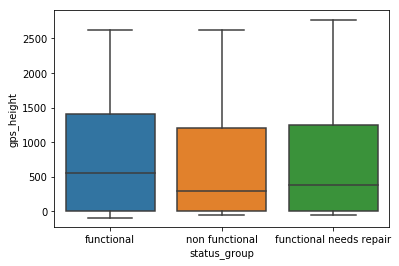

Feature Name:  longitude
Feature Type:  float64
Sample Data:  [34.93809275, 34.6987661, 37.46066446, 38.48616088, 31.13084671] ...... [37.16980689, 35.24999126, 34.01708706, 35.86131531, 38.10404822]


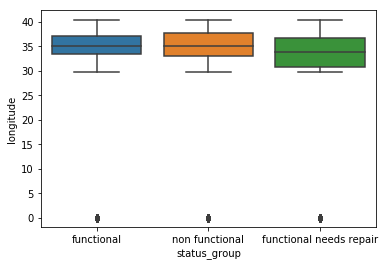

Feature Name:  latitude
Feature Type:  float64
Sample Data:  [-9.85632177, -2.14746569, -3.82132853, -11.15529772, -1.82535885] ...... [-3.25384746, -9.0706288, -8.75043433, -6.37857327, -6.74746425]


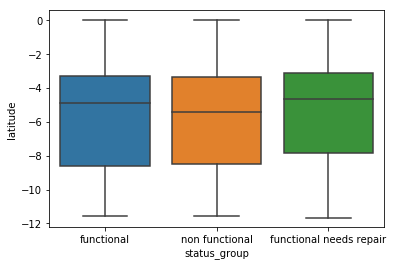

Feature Name:  wpt_name
Feature Type:  object
Sample Data:  ['none', 'Zahanati', 'Kwa Mahundi', 'Zahanati Ya Nanyumbu', 'Shuleni'] ...... ['Area Three Namba 27', 'Kwa Yahona Kuvala', 'Mashine', 'Mshoro', 'Kwa Mzee Lugawa']
status_group               functional  functional needs repair  non functional
wpt_name                                                                      
24                                  0                        0               1
A Kulwa                             0                        0               1
A Saidi                             1                        0               0
Abass                               1                        0               0
Abbas                               1                        0               0
Abdala Hamisi                       1                        0               0
Abdala Mwandute                     0                        0               1
Abdalaa                             0                        0    

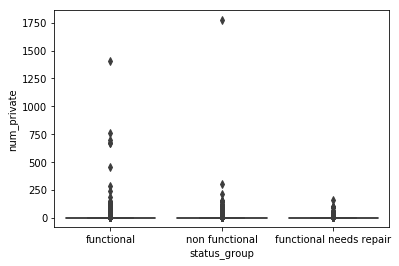

Feature Name:  basin
Feature Type:  object
Sample Data:  ['Lake Nyasa', 'Lake Victoria', 'Pangani', 'Ruvuma / Southern Coast', 'Lake Victoria'] ...... ['Pangani', 'Rufiji', 'Rufiji', 'Rufiji', 'Wami / Ruvu']
status_group             functional  functional needs repair  non functional
basin                                                                       
Internal                       4482                      557            2746
Lake Nyasa                     3324                      250            1511
Lake Rukwa                     1000                      270            1184
Lake Tanganyika                3107                      742            2583
Lake Victoria                  5100                      989            4159
Pangani                        5372                      477            3091
Rufiji                         5068                      437            2471
Ruvuma / Southern Coast        1670                      326            2497
Wami / Ruvu           

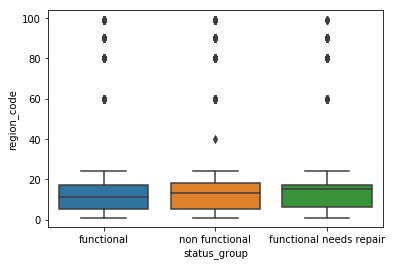

Feature Name:  district_code
Feature Type:  int64
Sample Data:  [5, 2, 4, 63, 1] ...... [5, 4, 7, 4, 2]


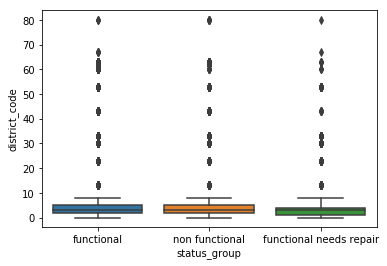

Feature Name:  lga
Feature Type:  object
Sample Data:  ['Ludewa', 'Serengeti', 'Simanjiro', 'Nanyumbu', 'Karagwe'] ...... ['Hai', 'Njombe', 'Mbarali', 'Chamwino', 'Morogoro Rural']
status_group      functional  functional needs repair  non functional
lga                                                                  
Arusha Rural             875                       48             329
Arusha Urban              42                        7              14
Babati                   381                       53              77
Bagamoyo                 730                        2             265
Bahi                     158                        0              66
Bariadi                  580                      409             188
Biharamulo               274                       21             108
Bukoba Rural             224                       97             166
Bukoba Urban              46                       10              32
Bukombe                  314                     

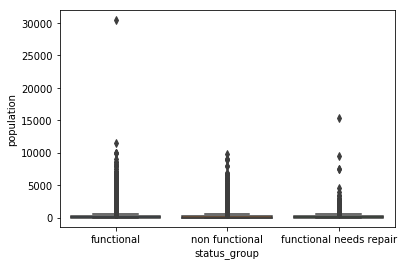

Feature Name:  recorded_by
Feature Type:  object
Sample Data:  ['GeoData Consultants Ltd', 'GeoData Consultants Ltd', 'GeoData Consultants Ltd', 'GeoData Consultants Ltd', 'GeoData Consultants Ltd'] ...... ['GeoData Consultants Ltd', 'GeoData Consultants Ltd', 'GeoData Consultants Ltd', 'GeoData Consultants Ltd', 'GeoData Consultants Ltd']
status_group             functional  functional needs repair  non functional
recorded_by                                                                 
GeoData Consultants Ltd       32259                     4317           22824
Feature Name:  construction_year
Feature Type:  int64
Sample Data:  [1999, 2010, 2009, 1986, 0] ...... [1999, 1996, 0, 0, 2002]


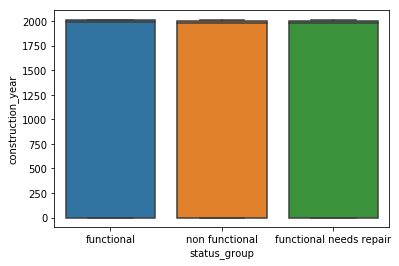

Feature Name:  extraction_type
Feature Type:  object
Sample Data:  ['gravity', 'gravity', 'gravity', 'submersible', 'gravity'] ...... ['gravity', 'gravity', 'swn 80', 'nira/tanira', 'nira/tanira']
status_group               functional  functional needs repair  non functional
extraction_type                                                               
afridev                          1200                       42             528
cemo                               45                        9              36
climax                              8                        0              24
gravity                         16048                     2701            8031
india mark ii                    1448                       79             873
india mark iii                     44                        1              53
ksb                               703                       26             686
mono                             1082                      129            1654
nira/tanira  

status_group    functional  functional needs repair  non functional
quantity_group                                                     
dry                    157                       37            6052
enough               21648                     2400            9138
insufficient          7916                     1450            5763
seasonal              2325                      416            1309
unknown                213                       14             562
Feature Name:  source
Feature Type:  object
Sample Data:  ['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'rainwater harvesting'] ...... ['spring', 'river', 'machine dbh', 'shallow well', 'shallow well']
status_group          functional  functional needs repair  non functional
source                                                                   
dam                          253                       24             379
hand dtw                     497                       17             360
lake           

In [11]:
def helper_summarize(row,target_column, target_column_type):
    '''
        Function used to generate the plots/tables for each feature in the dataset. 
    '''
    print("Feature Name: ", row['name'])
    print("Feature Type: ", row['type'])
    print("Sample Data: ",row['first_five'],"......",row['last_five'])
    temp_df = t_df[[row['name'],target_column]]
    if row['type'] == "object" and target_column_type == "object": #both categorical variables
        print(get_contingency_table(temp_df))
    elif row['type'] in ["int64","float64"] and target_column_type == "object": #continous + categorical
        get_box_plot(temp_df)

def summarize_dataset(df,dependent_variable = None):
    '''
        Base function using which the subsequent functions will be called.
    '''
    if not (isinstance(df, pd.core.frame.DataFrame)):
        raise TypeError("Type exception occured. Expecting a dataframe.")
    if dependent_variable is None:
        dependent_variable = df.columns[-1]
        warning.warn("As the dependent_variable was not used, we assume that the last column of your dataframe as the dependent variable")
    df_ = describe_df(df)
    for idx,row in df_.iterrows():
        if row['name'] != dependent_variable:
            helper_summarize(row,dependent_variable,"object")
summarize_dataset(t_df,"status_group")